# BE MI Filled adapted to our project

# Introduction

The goal of this notebook is to provide a simple and efficient implementation of the BE-MI Filled notebook (seen in Neuro IA classes). (path might not be relevant)

In [1]:
from preprocessing import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import mne
import os

In [2]:
FILE_PATH = './../../data/raw/Data_npy/DATA_001_Trial1.npy'
data_loader = DataLoader(FILE_PATH)
raws_left_arm = data_loader.get_raws(side='G')
raws_right_arm = data_loader.get_raws(side='D')
raws_left_arm.ch_names

FMIN = 1
FMAX = 40
EPOCHS_TMIN = -2
EPOCHS_TMAX = 2

WINDOW_DURATION = 0.5
STEP_DURATION = 0.2
LABEL_START = -EPOCHS_TMIN + 0 
LABEL_END = -EPOCHS_TMIN + 2

RANDOM_STATE = 42


CHANNELS = ['F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz', 'F4', 'C4', 'P4']

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from mne.decoding import CSP

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [3]:
def create_sliding_windows(array, window_duration, step_duration, label_start_t, label_end_t, sfreq=1024, verbose=False):
    # array shape = (n_channels, n_times)
    # new_array shape = (n_windows, n_channels, window_size)
    window_size = int(window_duration * sfreq)
    step_size = int(step_duration * sfreq)
    label_start = int(label_start_t * sfreq)
    label_end = int(label_end_t * sfreq)
    n_channels, n_times = array.shape
    n_windows = int((n_times - window_size) / step_size) + 1
    new_array = np.zeros((n_windows, n_channels, window_size))
    labels = np.zeros(n_windows)
    for i in range(n_windows):
        new_array[i] = array[:, i*step_size:i*step_size+window_size]
        if i*step_size+window_size < label_start or i*step_size > label_end:
            labels[i] = 0
        else:
            labels[i] = 1
    if verbose:
        print(f"window_size = {window_size}")
        print(f"step_size = {step_size}")
        print(f"label_start = {label_start}")
        print(f"label_end = {label_end}")
        print(f"n_channels = {n_channels}")
        print(f"n_times = {n_times}")
        print(f"n_windows = {n_windows}")
        print(f"new_array shape = {new_array.shape}")
        print(f"labels shape = {labels.shape}")         
    return new_array, labels
    

In [4]:
def preproc(file_path_list):
    slided_windows = np.zeros((0, 64, int(WINDOW_DURATION*1024)))
    labels = np.zeros(0)
    for file in file_path_list:
        data_loader = DataLoader(file)
        for side in ['D', 'G']:
            raws = data_loader.get_raws(side=side)
            if raws is None:
                continue
            raws.filter(FMIN, FMAX, fir_design='firwin')
            events = mne.find_events(raws, stim_channel=['movement'])
            picks = mne.pick_types(raws.info, eeg=True, stim=False)
            epochs = mne.Epochs(raws, events, event_id=1, tmin=EPOCHS_TMIN, tmax=EPOCHS_TMAX, picks=picks, baseline=None, preload=True)
            epochs_data = epochs.get_data()
            for i in range(len(epochs_data)):
                array, label = create_sliding_windows(epochs_data[i], WINDOW_DURATION, STEP_DURATION, LABEL_START, LABEL_END, sfreq=raws.info['sfreq'])
                slided_windows = np.concatenate((slided_windows, array), axis=0)
                labels = np.concatenate((labels, label), axis=0)
    return slided_windows, labels

In [5]:
def train_evaluate(slided_windows, labels, pipeline):

    ALL_CHANELS = ['AF3','AF4','AF7','AF8','AFz','C1','C2','C3','C4','C5','C6','CP1','CP2','CP3','CP4','CP5','CP6','CPz','Cz','F1','F2','F3','F4','F5','F6','F7','F8','FC1','FC2','FC3','FC4','FC5','FC6','FCz','FT7','FT8','Fp1','Fp2','Fpz','Fz','Iz','O1','O2','Oz','P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','PO3','PO4','PO7','PO8','POz','Pz','T7','T8','TP7','TP8','AC','VAC','AC3d','VAC3d', 'movement']
    channel_idx = [ALL_CHANELS.index(channel) for channel in CHANNELS]


    cv = ShuffleSplit(4, test_size=0.2, random_state=RANDOM_STATE)
    data_train, data_test, labels_train, labels_test = train_test_split(slided_windows[:,channel_idx,:], labels, test_size=0.2, random_state=RANDOM_STATE)

    scores = cross_val_score(pipeline, slided_windows[:,channel_idx,:], labels, cv=cv, n_jobs=1, scoring='balanced_accuracy')
    print(scores.mean())

    return scores.mean()

In [20]:
FMIN = 1
FMAX = 40
EPOCHS_TMIN = -2
EPOCHS_TMAX = 2

WINDOW_DURATION = 0.5
STEP_DURATION = 0.2
LABEL_START = -EPOCHS_TMIN + 0 
LABEL_END = -EPOCHS_TMIN + 2

RANDOM_STATE = 42

csp = CSP(n_components=4, reg='empirical', log=True, norm_trace=False)
clf = LinearDiscriminantAnalysis()
pipeline = Pipeline([('CSP', csp), ('LDA', clf)])

CHANNELS = ['F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz', 'F4', 'C4', 'P4']

FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

slided_windows, labels = preproc(FILE_PATH_LIST[:20])
scores = train_evaluate(slided_windows, labels, pipeline)


0.6707317090871961


In [19]:
FMIN = 1
FMAX = 40
EPOCHS_TMIN = -2
EPOCHS_TMAX = 2

WINDOW_DURATION = 0.5
STEP_DURATION = 0.2
LABEL_START = -EPOCHS_TMIN + 0 
LABEL_END = -EPOCHS_TMIN + 2

RANDOM_STATE = 42

csp = CSP(n_components=4, reg='empirical', log=True, norm_trace=False)
clf = LinearDiscriminantAnalysis()
pipeline = Pipeline([('CSP', csp), ('LDA', clf)])

CHANNELS = ['F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz', 'F4', 'C4', 'P4']

FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]


slided_windows, labels = preproc(FILE_PATH_LIST[:10])
scores = train_evaluate(slided_windows, labels, pipeline)

0.6849563946032378


In [18]:
FMIN = 1
FMAX = 40
EPOCHS_TMIN = -2
EPOCHS_TMAX = 2

WINDOW_DURATION = 0.5
STEP_DURATION = 0.2
LABEL_START = -EPOCHS_TMIN + 0 
LABEL_END = -EPOCHS_TMIN + 2

cov = Covariances(estimator='scm')
ts = TangentSpace()
ss = StandardScaler()
rf = RandomForestClassifier() 
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('rf', rf)])

CHANNELS = ['F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz', 'F4', 'C4', 'P4']

FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

slided_windows, labels = preproc(FILE_PATH_LIST[:10])
scores = train_evaluate(slided_windows, labels, pipeline)


0.7658170643460386


In [22]:
cov = Covariances(estimator='scm')
ts = TangentSpace()
ss = StandardScaler()
rf = RandomForestClassifier() 
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('rf', rf)])

slided_windows, labels = preproc(FILE_PATH_LIST[:4])
scores = train_evaluate(slided_windows, labels, pipeline)

0.7934387357530359


In [23]:
cov = Covariances(estimator='scm')
ts = TangentSpace()
ss = StandardScaler()
rf = RandomForestClassifier() 
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('rf', rf)])

slided_windows, labels = preproc(FILE_PATH_LIST[:2])
scores = train_evaluate(slided_windows, labels, pipeline)

0.8086143092105262


In [34]:
FMIN = 1
FMAX = 40
EPOCHS_TMIN = -4
EPOCHS_TMAX = 4

WINDOW_DURATION = 3
STEP_DURATION = 0.2
LABEL_START = -EPOCHS_TMIN + 0 
LABEL_END = -EPOCHS_TMIN + 2

cov = Covariances(estimator='scm')
ts = TangentSpace()
ss = StandardScaler()
rf = RandomForestClassifier() 
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('rf', rf)])

CHANNELS = ['F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz', 'F4', 'C4', 'P4']

FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

slided_windows, labels = preproc(FILE_PATH_LIST[:2])
scores = train_evaluate(slided_windows, labels, pipeline)


0.9177631319647452


In [33]:
labels.shape

(120,)

In [31]:
labels.sum() / len(labels)

0.4166666666666667

0.7216098218068663
WINDOW_DURATION = 0.5
score = 0.7216098218068663
0.8189470539502619
WINDOW_DURATION = 0.7
score = 0.8189470539502619
0.8718673531300908
WINDOW_DURATION = 0.8999999999999999
score = 0.8718673531300908
0.8973251177430368
WINDOW_DURATION = 1.0999999999999999
score = 0.8973251177430368
0.9246755096468268
WINDOW_DURATION = 1.2999999999999998
score = 0.9246755096468268
0.914494542668535
WINDOW_DURATION = 1.4999999999999998
score = 0.914494542668535
0.9083567071902839
WINDOW_DURATION = 1.6999999999999997
score = 0.9083567071902839
0.9177400573566947
WINDOW_DURATION = 1.8999999999999997
score = 0.9177400573566947
0.9308271197389484
WINDOW_DURATION = 2.0999999999999996
score = 0.9308271197389484
0.8982831115962986
WINDOW_DURATION = 2.3
score = 0.8982831115962986
0.9169123187007175
WINDOW_DURATION = 2.4999999999999996
score = 0.9169123187007175
0.9287000443202322
WINDOW_DURATION = 2.6999999999999993
score = 0.9287000443202322
0.9582202386114407
WINDOW_DURATION = 2.899999999999

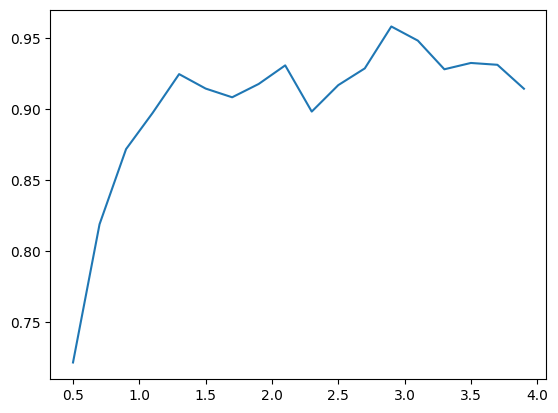

In [35]:
FMIN = 1
FMAX = 40
EPOCHS_TMIN = -5
EPOCHS_TMAX = 5

WINDOW_DURATION_LIST = list(np.arange(0.5, 4, 0.2))
STEP_DURATION = 0.2
LABEL_START = -EPOCHS_TMIN + 0 
LABEL_END = -EPOCHS_TMIN + 2

pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('rf', rf)])

scores_duration = []

for WINDOW_DURATION in WINDOW_DURATION_LIST:
    slided_windows, labels = preproc(FILE_PATH_LIST[:2])
    scores = train_evaluate(slided_windows, labels, pipeline)
    print(f"WINDOW_DURATION = {WINDOW_DURATION}")
    print(f"score = {scores.mean()}")
    scores_duration.append(scores.mean())

plt.plot(WINDOW_DURATION_LIST, scores_duration)


In [41]:
FMIN = 1
FMAX = 40
EPOCHS_TMIN = -5
EPOCHS_TMAX = 5

WINDOW_DURATION = 2
STEP_DURATION = 0.2
LABEL_START = -EPOCHS_TMIN + 0 
LABEL_END = -EPOCHS_TMIN + 2

cov = Covariances(estimator='scm')
ts = TangentSpace()
ss = StandardScaler()
rf = RandomForestClassifier() 
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('rf', rf)])

CHANNELS = ['F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz', 'F4', 'C4', 'P4']

FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

slided_windows, labels = preproc(FILE_PATH_LIST[:2])
scores = train_evaluate(slided_windows, labels, pipeline)

0.9247592543369654


In [43]:


FMIN = 1
FMAX = 40
EPOCHS_TMIN = -5
EPOCHS_TMAX = 5

WINDOW_DURATION = 2
STEP_DURATION = 0.2
LABEL_START = -EPOCHS_TMIN + 0 
LABEL_END = -EPOCHS_TMIN + 2

cov = Covariances(estimator='scm')
ts = TangentSpace()
ss = StandardScaler()
rf = GradientBoostingClassifier()
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('rf', rf)])

CHANNELS = ['F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz', 'F4', 'C4', 'P4']

FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

slided_windows, labels = preproc(FILE_PATH_LIST[:2])
scores = train_evaluate(slided_windows, labels, pipeline)

0.9149059031915643


In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

FMIN = 1
FMAX = 40
EPOCHS_TMIN = -5
EPOCHS_TMAX = 5

WINDOW_DURATION = 2
STEP_DURATION = 0.2
LABEL_START = -EPOCHS_TMIN + 0 
LABEL_END = -EPOCHS_TMIN + 2

cov = Covariances(estimator='scm')
ts = TangentSpace()
ss = StandardScaler()
rf = SVC()
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('rf', rf)])

CHANNELS = ['F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz', 'F4', 'C4', 'P4']

FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

slided_windows, labels = preproc(FILE_PATH_LIST[:2])
scores = train_evaluate(slided_windows, labels, pipeline)

0.9430215890931382


In [45]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

FMIN = 1
FMAX = 40
EPOCHS_TMIN = -5
EPOCHS_TMAX = 5

WINDOW_DURATION = 2
STEP_DURATION = 0.2
LABEL_START = -EPOCHS_TMIN + 0 
LABEL_END = -EPOCHS_TMIN + 2

cov = Covariances(estimator='scm')
ts = TangentSpace()
ss = StandardScaler()
rf = LogisticRegression()
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('rf', rf)])

CHANNELS = ['F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz', 'F4', 'C4', 'P4']

FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

slided_windows, labels = preproc(FILE_PATH_LIST[:2])
scores = train_evaluate(slided_windows, labels, pipeline)

0.8779890246833986


In [8]:
# training
FMIN = 1
FMAX = 40
EPOCHS_TMIN = -5
EPOCHS_TMAX = 5

WINDOW_DURATION = 2
STEP_DURATION = 0.2
LABEL_START = -EPOCHS_TMIN + 0 
LABEL_END = -EPOCHS_TMIN + 2

ALL_CHANELS = ['AF3','AF4','AF7','AF8','AFz','C1','C2','C3','C4','C5','C6','CP1','CP2','CP3','CP4','CP5','CP6','CPz','Cz','F1','F2','F3','F4','F5','F6','F7','F8','FC1','FC2','FC3','FC4','FC5','FC6','FCz','FT7','FT8','Fp1','Fp2','Fpz','Fz','Iz','O1','O2','Oz','P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','PO3','PO4','PO7','PO8','POz','Pz','T7','T8','TP7','TP8','AC','VAC','AC3d','VAC3d', 'movement']
CHANNELS = ['F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz', 'F4', 'C4', 'P4']
channel_idx = [ALL_CHANELS.index(channel) for channel in CHANNELS]

cov = Covariances(estimator='scm')
ts = TangentSpace()
ss = StandardScaler()
rf = SVC()
pipeline = Pipeline([('cov', cov), ('ts', ts), ('ss', ss), ('rf', rf)])

FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

slided_windows, labels = preproc(FILE_PATH_LIST[:2])
pipeline.fit(slided_windows[:,channel_idx,:], labels)


Pipeline(steps=[('cov', Covariances()), ('ts', TangentSpace()),
                ('ss', StandardScaler()), ('rf', SVC())])

In [24]:
# evaluating on full recording

data_loader = DataLoader(FILE_PATH_LIST[3])
raws = data_loader.get_raws(side='G')
raws.filter(FMIN, FMAX, fir_design='firwin')

data = raws.get_data()

slided_windows, labels = create_sliding_windows(data, WINDOW_DURATION, STEP_DURATION, LABEL_START, LABEL_END, sfreq=raws.info['sfreq'])

y_pred = pipeline.predict(slided_windows[:,channel_idx,:])


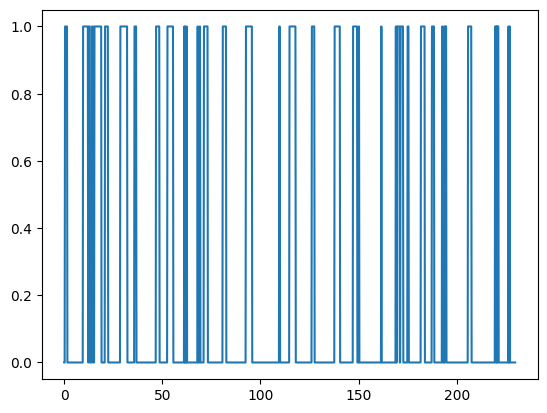

In [25]:
#plt.plot(y_pred)
time_y_pred = np.arange(0, len(y_pred)*0.2, 0.2)
plt.plot(time_y_pred, y_pred)

In [26]:
y_pred.shape

(1150,)

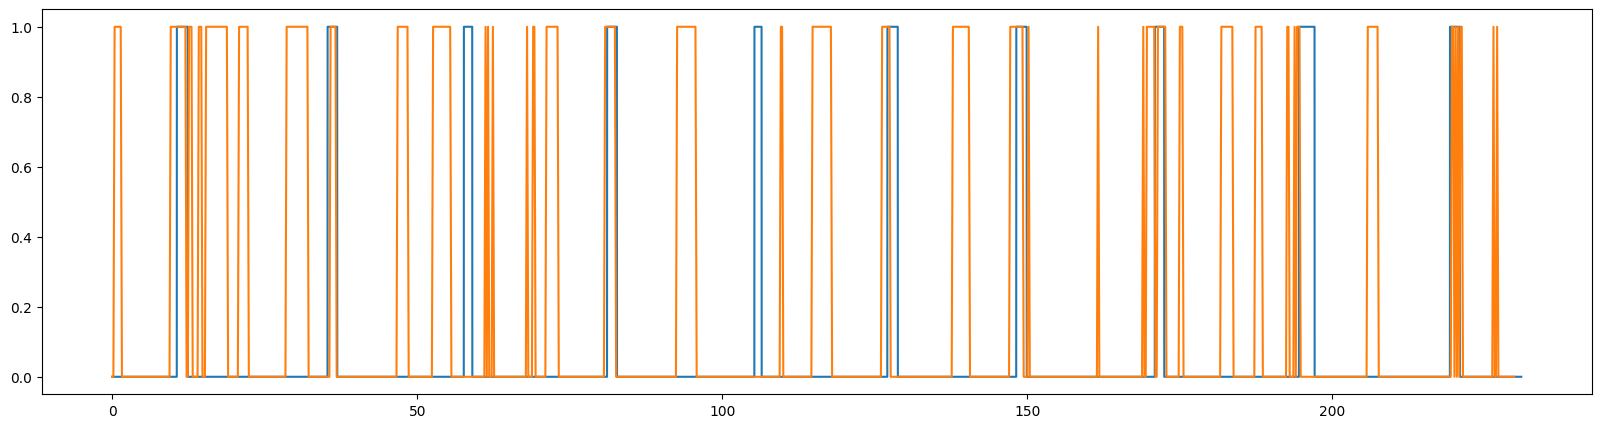

In [27]:
# y pred is movement or not each 0.2s for the next 3s
true_mvt = raws.get_data(picks=['movement'])[0]
true_mvt.shape
time = np.arange(0, len(true_mvt)) / raws.info['sfreq']
plt.figure(figsize=(20, 5))
plt.plot(time, true_mvt)
plt.plot(time_y_pred, y_pred)



In [ ]:
# Voir avec des proba de sortie
# changer la labélisation